In [8]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.1/873.1 kB 51.3 MB/s eta 0:00:00


In [1]:
# download dataset from gdrive
!gdown 1JGaS7kbeer8QqEeiSP3UcgE0npJzPTFK -O hagrid.zip


Downloading...
From (original): https://drive.google.com/uc?id=1JGaS7kbeer8QqEeiSP3UcgE0npJzPTFK
From (redirected): https://drive.google.com/uc?id=1JGaS7kbeer8QqEeiSP3UcgE0npJzPTFK&confirm=t&uuid=cde569ea-8535-4d89-a47c-10d4019c5e82
To: /content/hagrid.zip
100% 1.90G/1.90G [01:03<00:00, 29.8MB/s]


In [2]:
import os
import zipfile
zip_file_path = os.path.join('.', 'hagrid.zip')
dataset_dir = "hagrid"
# extract downloaded zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

os.remove(zip_file_path)

In [3]:
%rm -rf hagrid/__MACOSX/

In [4]:
hagrid_micro_dir = os.path.join(dataset_dir, 'HG_micro_3class')
%cat {hagrid_micro_dir}/data.yaml

train: hagrid/HG_micro_3class/train/images
val: hagrid/HG_micro_3class/valid/images
test: hagrid/HG_micro_3class/test/images

nc: 3
names: [fist,palm,no_gesture]


NOVI PRISTUP


In [5]:
!mkdir /content/datasets
!cp -r /content/hagrid/HG_micro_3class /content/datasets/hagrid

In [6]:
import yaml

with open('/content/datasets/hagrid/data.yaml', 'r') as file:
    data = yaml.safe_load(file)

data['train'] = './train/images'
data['val'] = './valid/images'
data['test'] = './test/images'

with open('/content/datasets/hagrid/data.yaml', 'w') as file:
    yaml.dump(data, file)



In [9]:
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt

model = YOLO("yolov8m.pt")

hyperparam_combinations = [
    {'lr0': 0.01, 'momentum': 0.9, 'weight_decay': 0.0005, 'warmup_epochs': 3.0},
    {'lr0': 0.001, 'momentum': 0.95, 'weight_decay': 0.0001, 'warmup_epochs': 5.0},
    {'lr0': 0.0001, 'momentum': 0.9, 'weight_decay': 0.0005, 'warmup_epochs': 2.0},
]

data = "/content/datasets/hagrid/data.yaml"

for i, params in enumerate(hyperparam_combinations):
    print(f"Training with combination {i+1}: {params}")
    results = model.train(
        data=data,
        epochs=10,
        batch=-1,   # Auto adjust
        **params
    )


100%|██████████| 49.7M/49.7M [00:00<00:00, 404MB/s]


Training with combination 1: {'lr0': 0.01, 'momentum': 0.9, 'weight_decay': 0.0005, 'warmup_epochs': 3.0}
Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/datasets/hagrid/data.yaml, epochs=10, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=F

100%|██████████| 755k/755k [00:00<00:00, 106MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 273MB/s]


AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.26G reserved, 0.24G allocated, 14.25G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    25858057       79.07         0.705         39.26         74.01        (1, 3, 640, 640)                    list
    25858057       158.1         1.040         32.39         42.11        (2, 3, 640, 640)                    list
    25858057       316.3         1.808         44.21          52.1        (4, 3, 640, 640)                    list
    25858057       632.6         3.272         80.48         89.12        (8, 3, 640, 640)                    list
    25858057        1265         6.132         154.8         175.5       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 22 for CUDA:0 8.82G/14.75G (60%) ✅


train: Scanning /content/datasets/hagrid/train/labels... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<00:00, 1599.48it/s]

train: New cache created: /content/datasets/hagrid/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/hagrid/valid/labels... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 1326.35it/s]

val: New cache created: /content/datasets/hagrid/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.9' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.000515625), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      9.23G     0.9457      2.964      1.096         12        640: 100%|██████████| 46/46 [00:51<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]

                   all        200        309      0.457      0.795      0.493       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      9.19G     0.8527     0.8918      1.038         11        640: 100%|██████████| 46/46 [00:46<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]

                   all        200        309      0.382      0.149      0.131     0.0908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      9.17G     0.8977     0.8819      1.086         15        640: 100%|██████████| 46/46 [00:47<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]

                   all        200        309      0.503      0.326      0.287      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      9.19G     0.8498      0.737      1.065         13        640: 100%|██████████| 46/46 [00:48<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]

                   all        200        309      0.689      0.508      0.529      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      9.09G     0.8051     0.6593      1.035         11        640: 100%|██████████| 46/46 [00:48<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]

                   all        200        309      0.901       0.82      0.892      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      9.21G     0.7794     0.5672      1.017         12        640: 100%|██████████| 46/46 [00:47<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]

                   all        200        309      0.937      0.853      0.926      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      9.19G      0.763     0.5391      1.007         14        640: 100%|██████████| 46/46 [00:46<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]

                   all        200        309       0.96      0.892      0.943      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      9.08G     0.6969     0.4607     0.9681         11        640: 100%|██████████| 46/46 [00:46<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]

                   all        200        309      0.957      0.895      0.952      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      9.19G     0.6707     0.4216     0.9635         11        640: 100%|██████████| 46/46 [00:48<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]

                   all        200        309       0.94      0.938      0.952      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      9.19G      0.635     0.3851     0.9393         14        640: 100%|██████████| 46/46 [00:45<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]

                   all        200        309      0.985      0.913      0.964      0.786



10 epochs completed in 0.159 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


                   all        200        309      0.985      0.913      0.964      0.786
                  fist        100        100      0.972          1      0.994      0.808
                  palm        100        100      0.995          1      0.995      0.894
            no_gesture        109        109      0.988      0.739      0.903      0.655
Speed: 0.3ms preprocess, 8.8ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs/detect/train
Training with combination 2: {'lr0': 0.001, 'momentum': 0.95, 'weight_decay': 0.0001, 'warmup_epochs': 5.0}
Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/datasets/hagrid/data.yaml, epochs=10, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic

train: Scanning /content/datasets/hagrid/train/labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/hagrid/valid/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.95' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=9.375e-05), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      8.48G     0.6298     0.3825     0.9364         22        640: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]

                   all        200        309      0.967      0.907      0.952      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      8.37G     0.6835     0.4377     0.9663         25        640: 100%|██████████| 50/50 [00:50<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]

                   all        200        309      0.957      0.907      0.953      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      8.46G     0.7073     0.4936     0.9743         26        640: 100%|██████████| 50/50 [00:50<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]

                   all        200        309      0.919      0.847      0.911      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      8.46G     0.7211     0.4831     0.9873         26        640: 100%|██████████| 50/50 [00:48<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]

                   all        200        309      0.956      0.844      0.928      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      8.45G     0.7105      0.478      0.981         24        640: 100%|██████████| 50/50 [00:49<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]

                   all        200        309      0.979      0.864       0.93      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      8.45G     0.6907     0.4716     0.9654         23        640: 100%|██████████| 50/50 [00:49<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]

                   all        200        309      0.974      0.884      0.952      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      8.35G     0.6884     0.4245     0.9667         28        640: 100%|██████████| 50/50 [00:53<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

                   all        200        309      0.955      0.911      0.958      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      8.45G     0.6347     0.3857     0.9374         23        640: 100%|██████████| 50/50 [00:50<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]

                   all        200        309      0.978        0.9      0.965      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      8.45G     0.6298      0.359     0.9307         23        640: 100%|██████████| 50/50 [00:49<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]

                   all        200        309      0.968      0.932      0.972      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      8.36G      0.597     0.3245     0.9069         25        640: 100%|██████████| 50/50 [00:49<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]

                   all        200        309      0.978      0.931      0.973      0.795



10 epochs completed in 0.164 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 52.0MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


                   all        200        309      0.978      0.932      0.973      0.794
                  fist        100        100       0.99      0.984      0.994      0.815
                  palm        100        100      0.997          1      0.995      0.887
            no_gesture        109        109      0.947      0.812       0.93       0.68
Speed: 0.2ms preprocess, 9.4ms inference, 0.0ms loss, 6.8ms postprocess per image
Results saved to runs/detect/train2
Training with combination 3: {'lr0': 0.0001, 'momentum': 0.9, 'weight_decay': 0.0005, 'warmup_epochs': 2.0}
Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/datasets/hagrid/data.yaml, epochs=10, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train22, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, determinist

train: Scanning /content/datasets/hagrid/train/labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/hagrid/valid/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/train22/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.9' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.00046875), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train22
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      8.51G      0.606     0.3565     0.9226         22        640: 100%|██████████| 50/50 [00:53<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]

                   all        200        309      0.957      0.901      0.957      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      8.49G     0.6815     0.4405      0.963         25        640: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

                   all        200        309       0.94      0.881      0.938      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      8.47G     0.7134     0.5166     0.9773         26        640: 100%|██████████| 50/50 [00:50<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]

                   all        200        309      0.827      0.847      0.893      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      8.39G     0.6895     0.4753     0.9725         26        640: 100%|██████████| 50/50 [00:50<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]

                   all        200        309      0.919      0.824      0.899      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      8.47G     0.6772      0.443     0.9632         24        640: 100%|██████████| 50/50 [00:49<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]

                   all        200        309      0.975       0.89      0.934      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      8.45G     0.6517     0.4205      0.946         23        640: 100%|██████████| 50/50 [00:51<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]

                   all        200        309      0.949      0.893      0.946      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      8.39G     0.6443     0.4109     0.9498         28        640: 100%|██████████| 50/50 [00:50<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

                   all        200        309       0.97      0.896      0.948      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      8.48G        0.6     0.3524      0.928         23        640: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]

                   all        200        309      0.979      0.904      0.956      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      8.45G     0.5947     0.3362     0.9208         23        640: 100%|██████████| 50/50 [00:48<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]

                   all        200        309      0.982      0.921       0.97      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      8.38G     0.5754     0.3076     0.9076         25        640: 100%|██████████| 50/50 [00:47<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]

                   all        200        309      0.962      0.936      0.969      0.786



10 epochs completed in 0.165 hours.
Optimizer stripped from runs/detect/train22/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train22/weights/best.pt, 52.0MB

Validating runs/detect/train22/weights/best.pt...
Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


                   all        200        309      0.982      0.921       0.97      0.789
                  fist        100        100      0.975       0.98      0.994      0.811
                  palm        100        100      0.994          1      0.995      0.891
            no_gesture        109        109      0.977      0.784      0.921      0.664
Speed: 0.2ms preprocess, 8.6ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs/detect/train22


In [ ]:
df = pd.read_csv('/content/runs/detect/train3/results.csv')
df.tail(1)

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
9,10,0.64174,0.85021,0.86803,0.97132,0.93224,0.97265,0.75144,0.81398,0.66367,0.90744,0.000156,0.000156,0.000156


{'lr0': 0.01, 'momentum': 0.9, 'weight_decay': 0.0005, 'warmup_epochs': 3.0}


,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
9,10,0.63496,0.38506,0.93931,0.9852,0.913,0.96411,0.78567,0.74859,0.46853,0.99473,0.000156,0.000156,0.000156


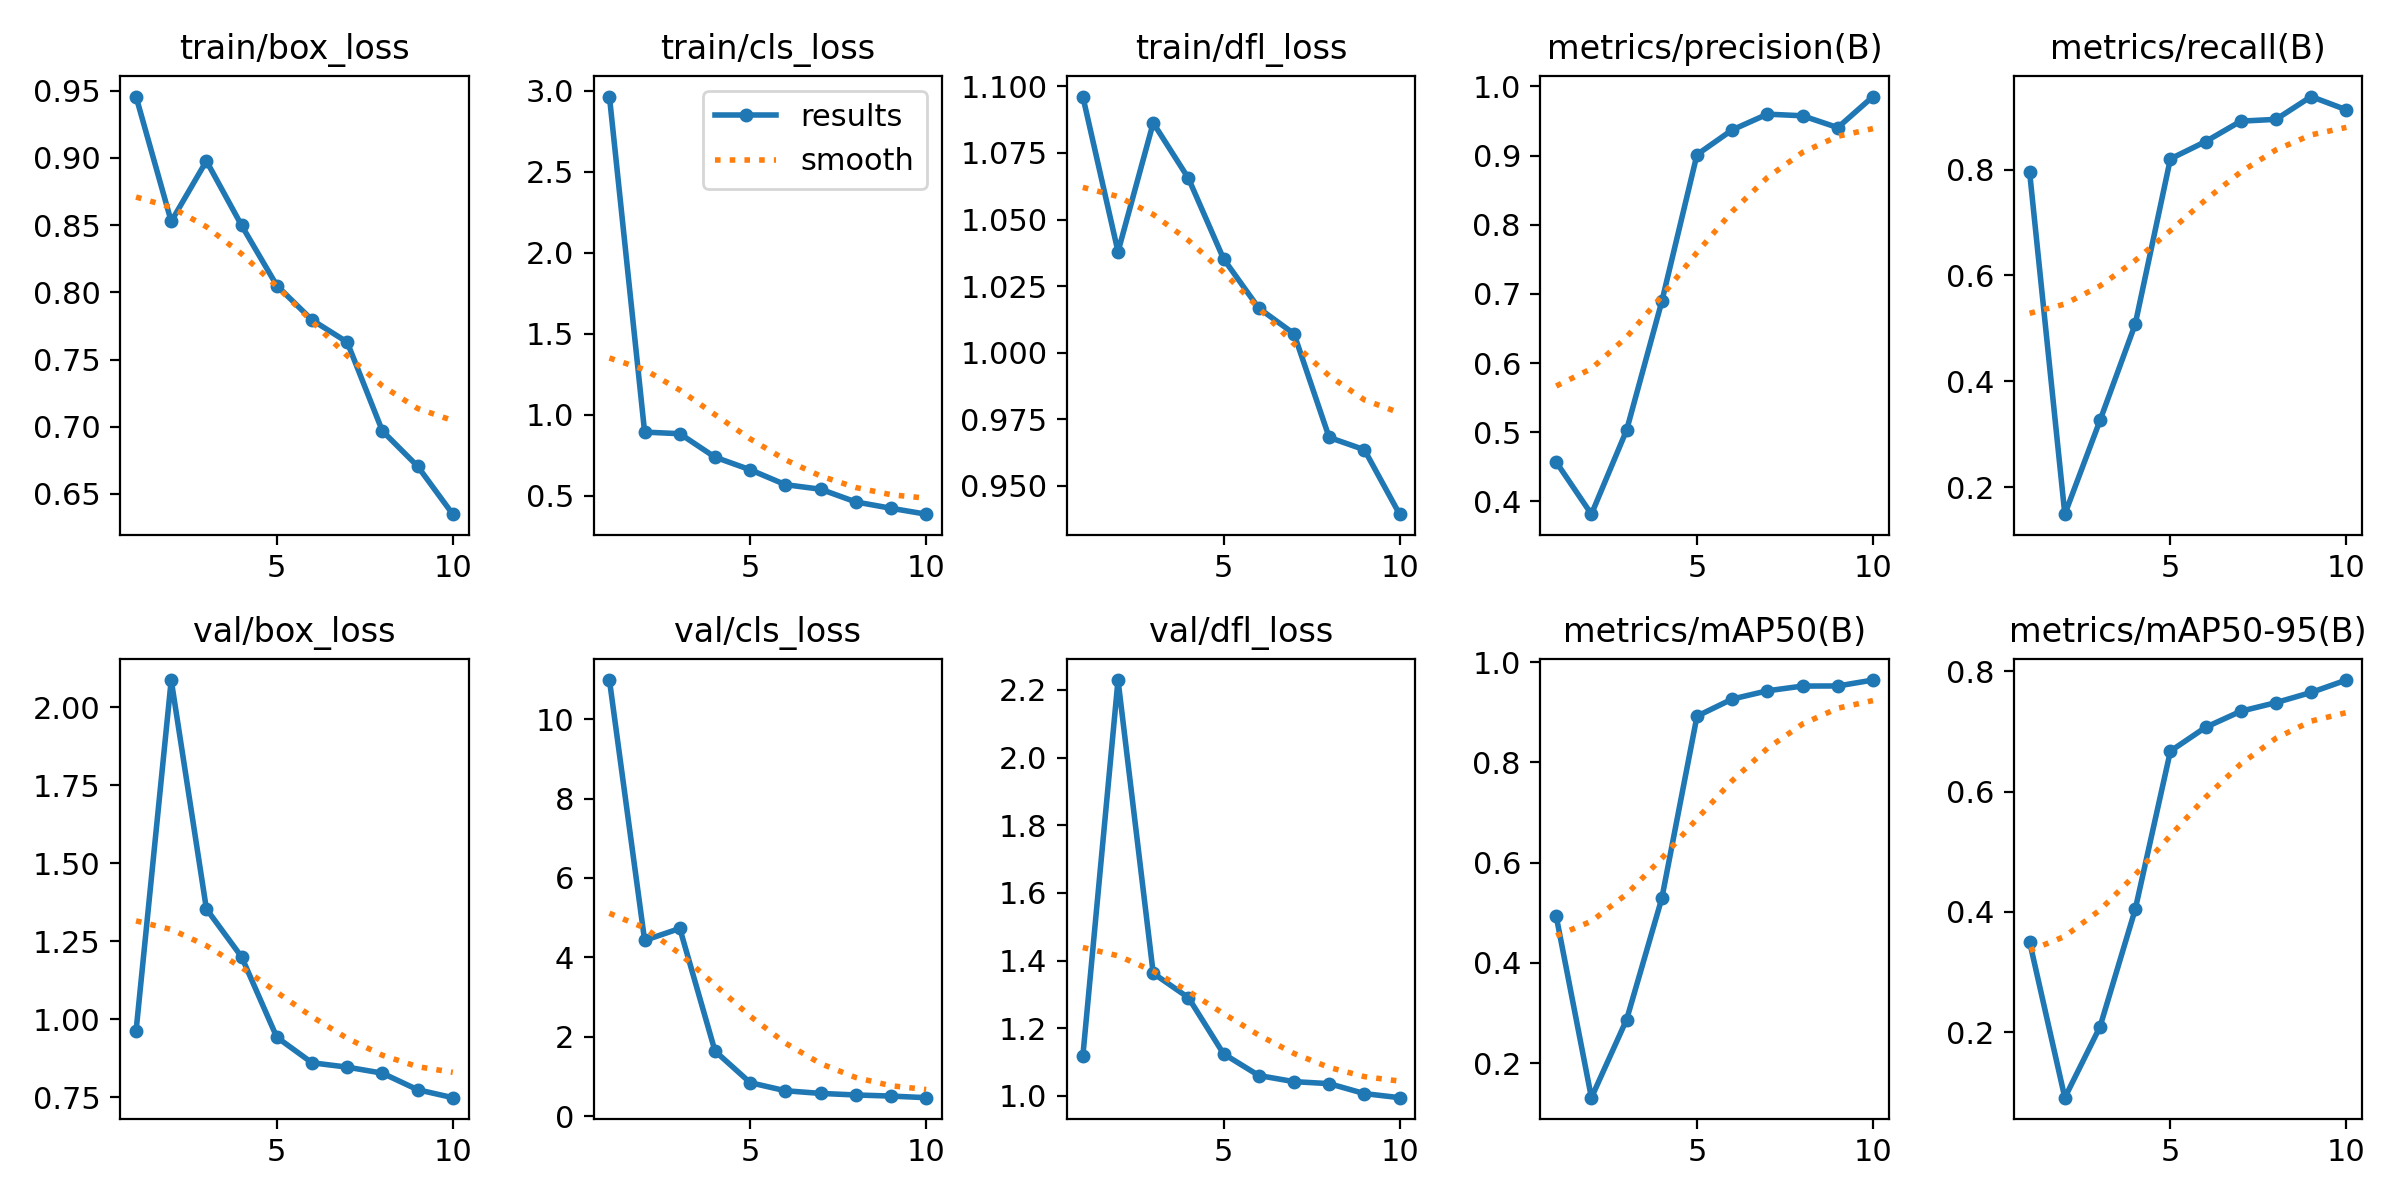

{'lr0': 0.001, 'momentum': 0.95, 'weight_decay': 0.0001, 'warmup_epochs': 5.0}


,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
9,10,0.59698,0.32448,0.90694,0.97776,0.93071,0.97314,0.79485,0.76151,0.4316,0.99737,0.000156,0.000156,0.000156


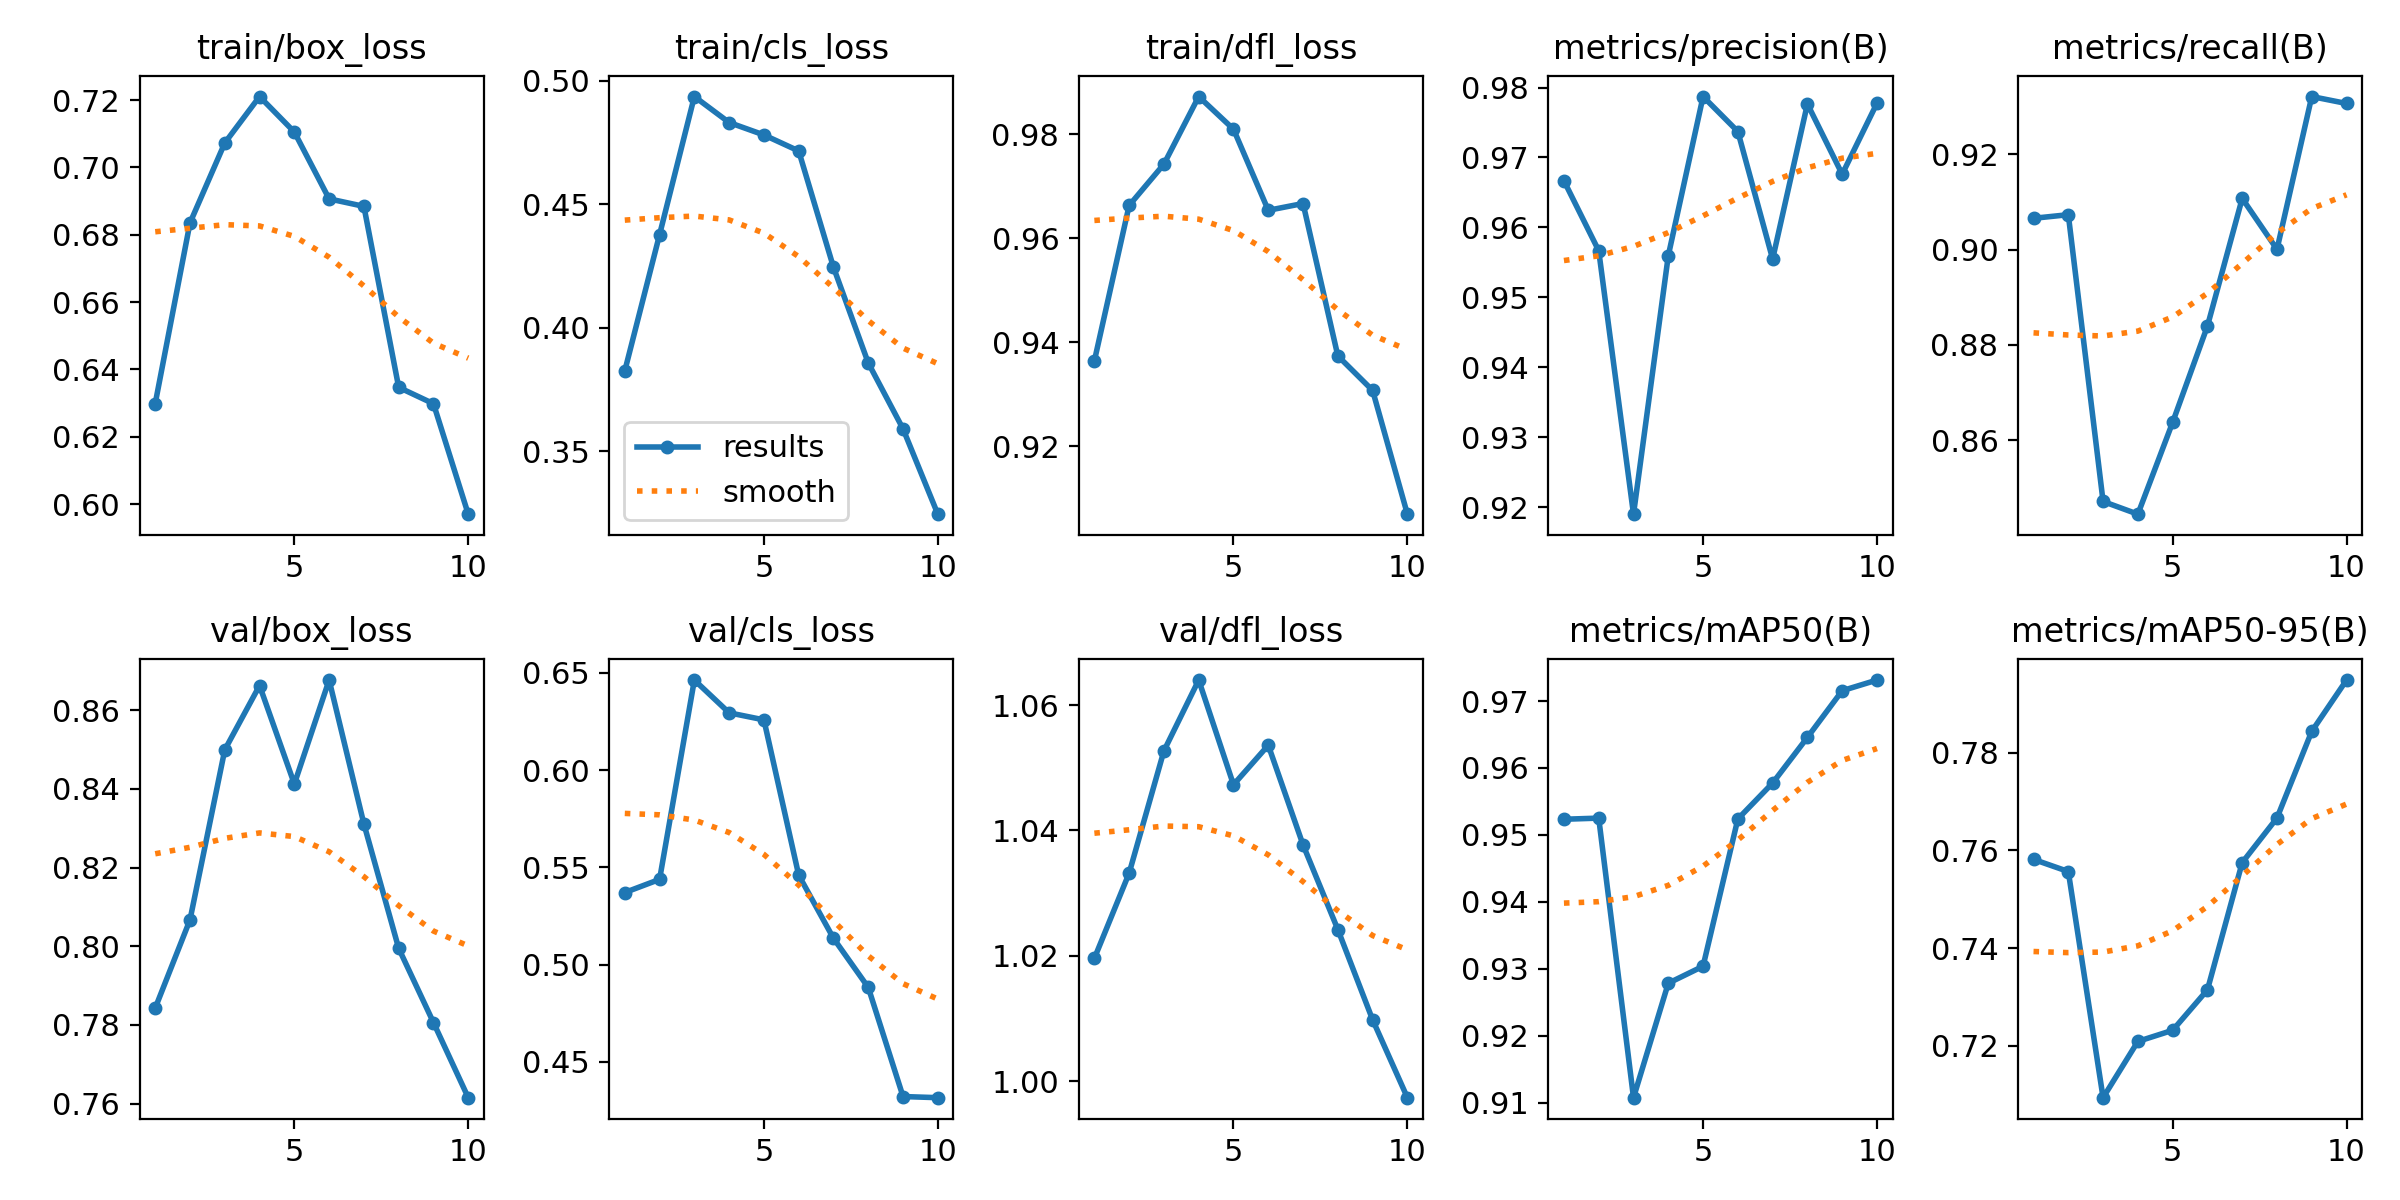

{'lr0': 0.0001, 'momentum': 0.9, 'weight_decay': 0.0005, 'warmup_epochs': 2.0}


,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
9,10,0.57539,0.30762,0.90755,0.96199,0.93577,0.96923,0.78628,0.77654,0.43506,1.019,0.000156,0.000156,0.000156


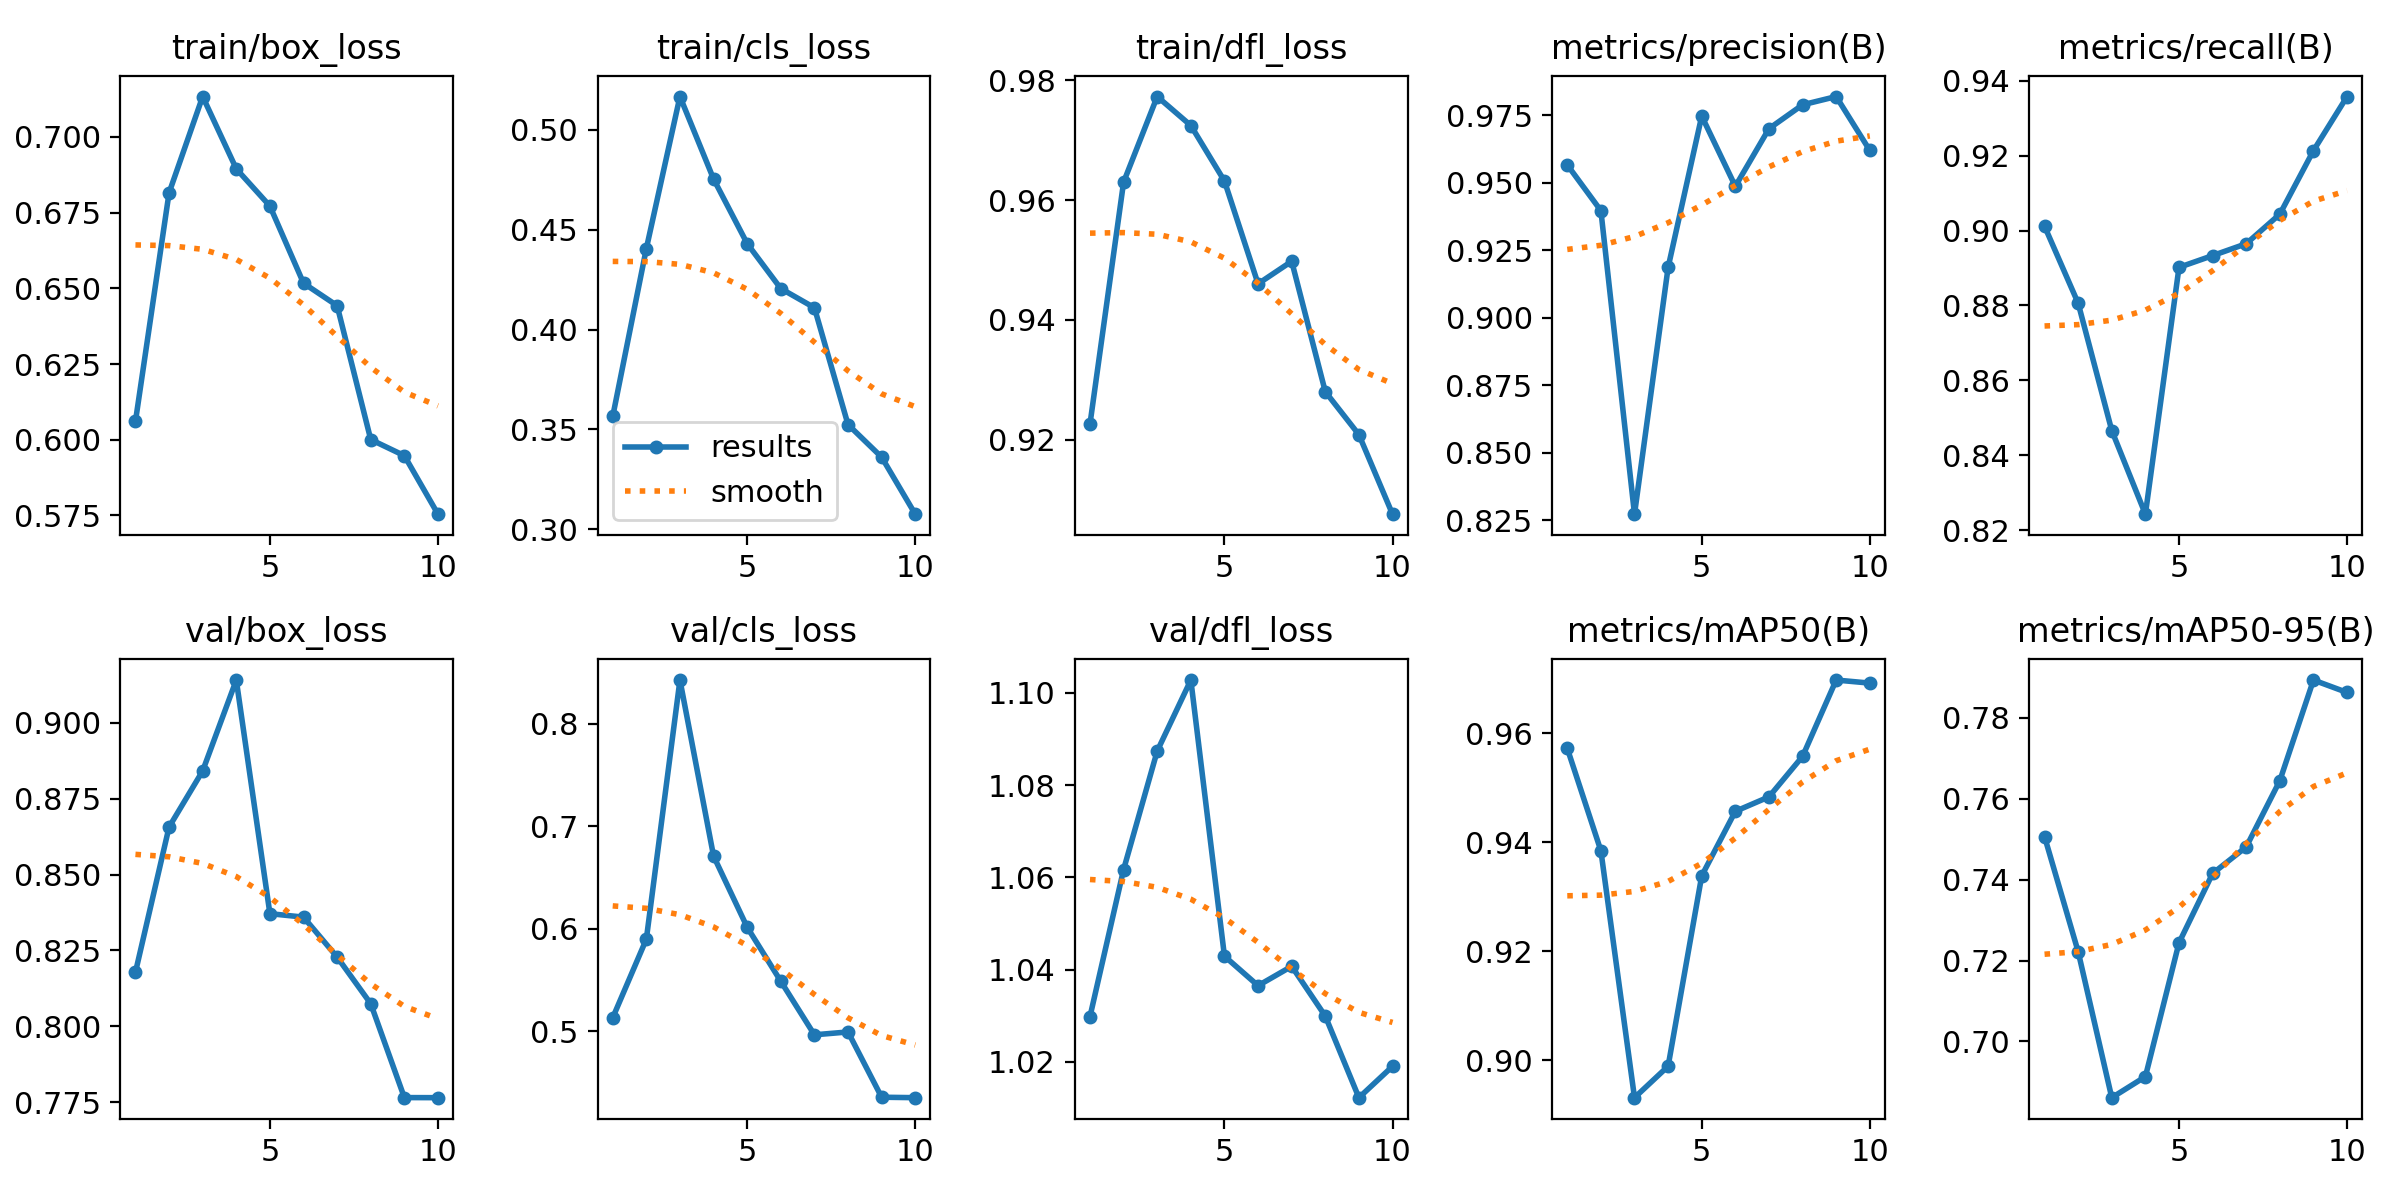

In [11]:
run_paths = ['/content/runs/detect/train/', '/content/runs/detect/train2/', '/content/runs/detect/train22/']

from IPython.display import Image, display


for i, path in enumerate(run_paths):
    print(hyperparam_combinations[i])

    res = pd.read_csv(path + 'results.csv')
    display(res.tail(1))

    display(Image(path + 'results.png'))



Conclusion: 3rd combination is the best

In [ ]:
!pip freeze > requirements.txt

In [12]:
from ultralytics import YOLO

# Load a model
# model = YOLO("yolov8n.pt")  # load an official model
model = YOLO(run_paths[2] + 'weights/best.pt')  # load a custom model

# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map  # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps  # a list contains map50-95 of each category

Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/datasets/hagrid/valid/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


                   all        200        309      0.968       0.93       0.97       0.79
                  fist        100        100       0.97      0.982      0.994      0.812
                  palm        100        100      0.991          1      0.995      0.892
            no_gesture        109        109      0.943      0.807      0.921      0.664
Speed: 0.6ms preprocess, 21.0ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/val


array([    0.81222,     0.89249,      0.6641])

In [15]:
results = model.predict('/content/datasets/hagrid/test/images', save=True)


image 1/200 /content/datasets/hagrid/test/images/00a07a41-3c4e-41ec-91ec-8bc39baa30f0.jpg: 640x480 1 palm, 28.9ms
image 2/200 /content/datasets/hagrid/test/images/00af0ce3-aeb6-428f-a0e0-52578b7e6bff.jpg: 640x480 1 palm, 27.7ms
image 3/200 /content/datasets/hagrid/test/images/00b0e1bb-c13b-4264-84e5-0075e11fd6fb.jpg: 640x480 1 palm, 27.7ms
image 4/200 /content/datasets/hagrid/test/images/00b42c58-2115-4146-b23b-d7ec02666edd.jpg: 640x480 1 palm, 27.7ms
image 5/200 /content/datasets/hagrid/test/images/00b5aa33-5c4c-4cbf-af40-79b9e9cfc1ea.jpg: 640x480 1 fist, 27.7ms
image 6/200 /content/datasets/hagrid/test/images/00c17c3b-4098-4a11-bf87-2b43b551fd26.jpg: 640x480 1 fist, 28.7ms
image 7/200 /content/datasets/hagrid/test/images/00c6b2cb-d179-40f0-b898-dd22b75779b6.jpg: 384x640 1 palm, 1 no_gesture, 26.3ms
image 8/200 /content/datasets/hagrid/test/images/00c7d49c-b6bf-4842-9ba7-0cb6af2f6b43.jpg: 480x640 1 fist, 29.2ms
image 9/200 /content/datasets/hagrid/test/images/00cf64ad-5869-4e90-9264-

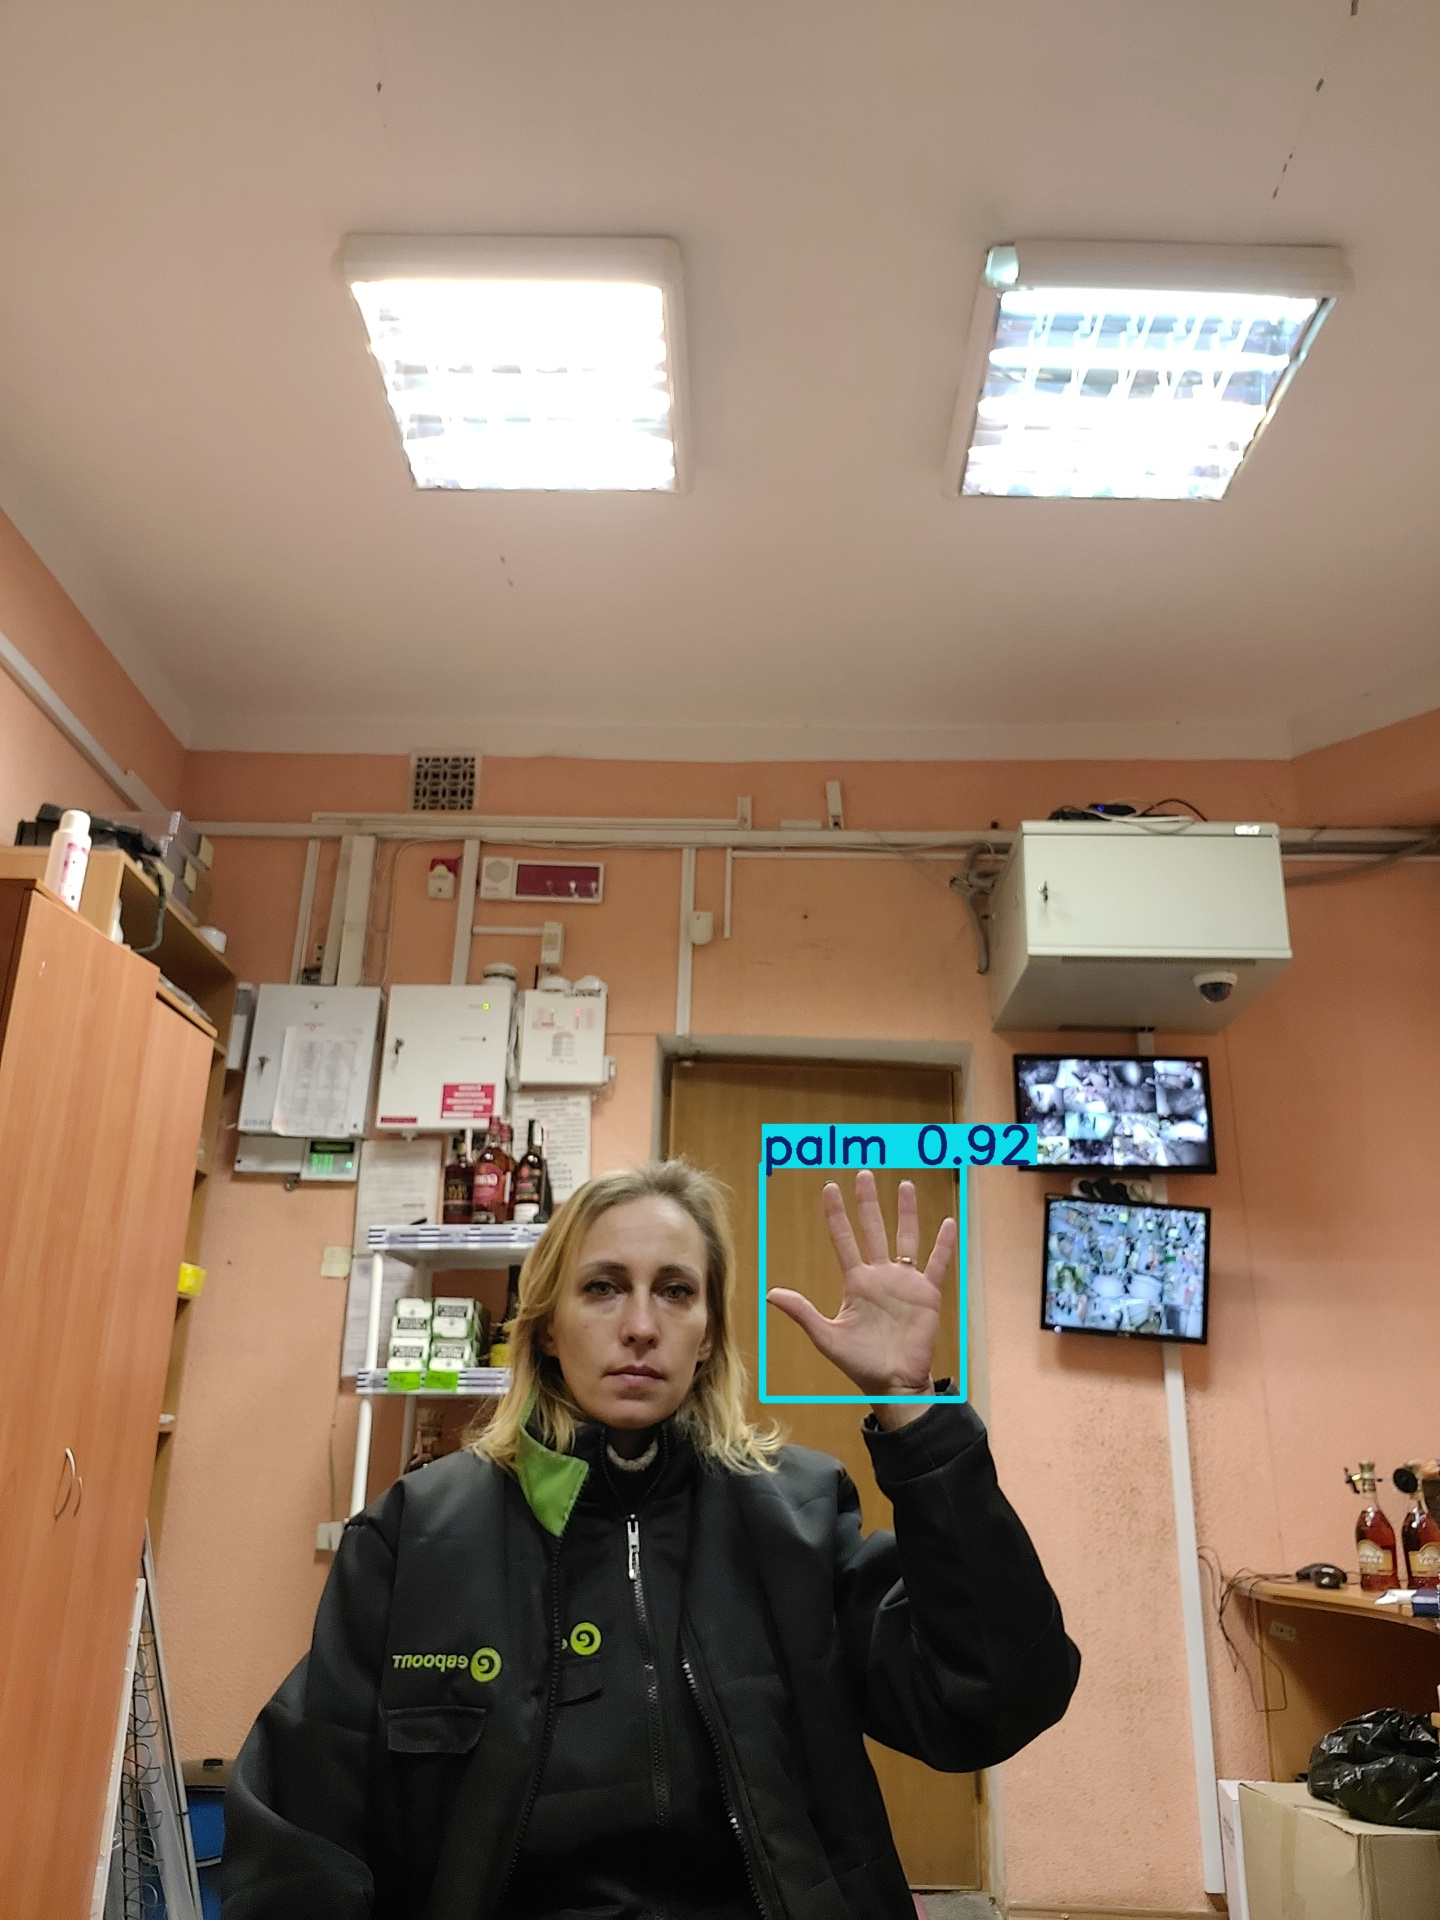

In [16]:
from IPython.display import Image
Image('/content/runs/detect/predict/00a07a41-3c4e-41ec-91ec-8bc39baa30f0.jpg')

In [24]:
results = model.val( split='test')  # Specify 'test' split


Ultralytics YOLOv8.2.97 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/datasets/hagrid/test/labels... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 1023.65it/s]

val: New cache created: /content/datasets/hagrid/test/labels.cache



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:13<00:00,  1.02s/it]


                   all        200        250       0.99      0.958       0.97      0.811
                  fist        106        106      0.999          1      0.995      0.842
                  palm         94         94      0.993          1      0.995      0.914
            no_gesture         50         50      0.978      0.874      0.919      0.676
Speed: 0.3ms preprocess, 18.6ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/detect/val5


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!cp -r /content/runs/detect/train22 /content/drive/MyDrive/handwave_model/runs